### **Introduction**

Kaggle's **Titanic - Machine Learning from Disaster** is a classic introductory problem for getting familiar with the fundamentals of machine learning.
In this notebook...


### **Where to start?**

https://www.kaggle.com/code/alexisbcook/titanic-tutorial/notebook

Alexis provides a brief introduction for making a submission to kaggle with some sample code for this challenge. She uses a random forest classifier for the model in her example.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os

PATH = "../input/titanic/" # file path to the datasets

for dirname, _, filenames in os.walk('PATH'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Load Datasets

In [8]:
train_data = pd.read_csv(PATH + "train.csv")
test_data = pd.read_csv(PATH + "test.csv")

In [9]:

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model_orignial = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model_orignial.fit(X, y)
predictions = model_orignial.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### Results
The submission of this model resulted in a score of 0.77511

### **Contribution**
<!-- We can start with this as our baseline and change a few things to see if we 
get a better result. The first and easisest thing to do is tune the hyperparameters for the Random Forest Classifier and compare the results with the original submission. -->
### Part 1
We can start by looking for entries in the dataset that we can dropout or modify to improve the performance of the model (explain). There are no duplicates in the dataset based on the given description of the passenger ID column which is unique to every entry and not null. There are missing values in other columns that we can explore.

Total number of rows: 1309

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
Name: missing values, dtype: int64


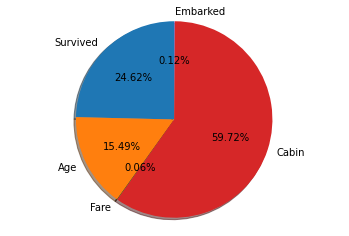

In [164]:
data = pd.concat([train_data, test_data])

missing_vals = [data[col].isnull().sum() for col in data.columns.to_list()]
labels = data.columns.to_list()
ser = pd.Series(data=missing_vals, index=labels, name="missing values")
ser_missing = ser[ser > 0]

percentages = ser_missing.apply(lambda x: x / data.shape[0])
fig1, ax1 = plt.subplots()
ax1.pie(percentages.values, labels=percentages.index, autopct='%1.2f%%',
        shadow=True, startangle=90, labeldistance=1.1)
ax1.axis('equal')

print(f"Total number of rows: {data.shape[0]}\n\n{ser_missing}")
plt.show()


Since the number of missing values for `Fare` and `Embarked` column is negligible, it is best to simply drop these entries from our dataset. However, there are a considerable amount of missing values for the `Survived`, `Age`, and `Cabin` columns. A convenient approach to this problem would be to fill the missing values with the mean of the column.